# 🛡️ UNSW-NB15 Intrusion Detection Model Retraining

This notebook retrains a model for intrusion detection using the UNSW-NB15 dataset. The workflow includes:
1. Importing libraries
2. Loading the dataset
3. Data cleaning
4. Encoding categorical features
5. Model training
6. Evaluation
7. Saving model and preprocessing objects

In [ ]:
import pandas as pd
import joblib
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# --- Step 1: Load datasets ---
train_df = pd.read_csv("UNSW_NB15_training-set.csv")
test_df = pd.read_csv("UNSW_NB15_testing-set.csv")

# Drop unnecessary columns
drop_cols = ['id', 'attack_cat']
train_df = train_df.drop(columns=[col for col in drop_cols if col in train_df.columns], errors='ignore')
test_df = test_df.drop(columns=[col for col in drop_cols if col in test_df.columns], errors='ignore')

# Define label column
LABEL_COL = "label"
y_train = train_df[LABEL_COL].apply(lambda x: 0 if x == 0 else 1)
X_train = train_df.drop(columns=[LABEL_COL])
y_test = test_df[LABEL_COL].apply(lambda x: 0 if x == 0 else 1)
X_test = test_df.drop(columns=[LABEL_COL])

# --- Step 2: Encode categorical values ---
categorical_cols = ['proto', 'service', 'state']
encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    # Fit on combined unique values from train and test to ensure consistent encoding
    combined_values = pd.concat([X_train[col], X_test[col]], axis=0).astype(str).unique()
    le.fit(combined_values)
    X_train[col] = le.transform(X_train[col].astype(str))
    X_test[col] = le.transform(X_test[col].astype(str))
    encoders[col] = le

# Save encoders for future use
joblib.dump(encoders, "unsw_encoders.pkl")

# --- Step 3: Handle missing values ---

X_train = X_train.fillna(X_train.median())
X_test = X_test.fillna(X_test.median())


# --- Step 4: Apply SMOTE to handle class imbalance ---
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)
print("SMOTE applied. New training set shape:", X_train.shape)

# --- Step 5: Hyperparameter tuning for Random Forest ---
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'bootstrap': [True, False]
}

# Optional: Use a subset for faster tuning (comment out for full dataset)
X_train_subset, _, y_train_subset, _ = train_test_split(
    X_train, y_train, test_size=0.8, random_state=42, stratify=y_train
)

clf = RandomForestClassifier(random_state=42, n_jobs=-1)
grid_search = GridSearchCV(
    clf, param_grid, cv=3, scoring='f1', n_jobs=-1, verbose=1
)
grid_search.fit(X_train_subset, y_train_subset)  # Use subset for tuning

# Train the best model on the full (SMOTE-resampled) training set
best_clf = grid_search.best_estimator_
best_clf.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best CV F1 score (on subset):", grid_search.best_score_)

# --- Step 6: Evaluate ---
y_pred = best_clf.predict(X_test)
metrics = {
    "accuracy": accuracy_score(y_test, y_pred),
    "precision": precision_score(y_test, y_pred),
    "recall": recall_score(y_test, y_pred),
    "f1": f1_score(y_test, y_pred),
}
print(metrics)

# --- Step 7: Visualize confusion matrix ---
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Normal', 'Attack'], yticklabels=['Normal', 'Attack'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.savefig('confusion_matrix_rf.png')
plt.close()

# --- Step 8: Save model ---
joblib.dump(best_clf, "unsw_rf_full.pkl")
print("✅ Model and encoders saved successfully!")

SyntaxError: invalid syntax (318329734.py, line 180)

SMOTE applied. New training set shape: (238682, 42)

Training RandomForest...
Fitting 3 folds for each of 24 candidates, totalling 72 fits
RandomForest - Best parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
RandomForest - Best CV F1 score (on subset): 0.9587512152126828
RandomForest - Test metrics: {'accuracy': 0.8824393917310401, 'precision': 0.8341487188138484, 'recall': 0.9816685784876026, 'f1': 0.9019162756761686}

Training GradientBoosting...
Fitting 3 folds for each of 8 candidates, totalling 24 fits
GradientBoosting - Best parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}
GradientBoosting - Best CV F1 score (on subset): 0.9589545335528452
GradientBoosting - Test metrics: {'accuracy': 0.8910265753291551, 'precision': 0.8469333231556048, 'recall': 0.9790214418071119, 'f1': 0.9081998076411484}

Training XGBoost...
Fitting 3 folds for each of 8 candidates, totalling 24 fits
XGBoost - Best parameters: {'learnin

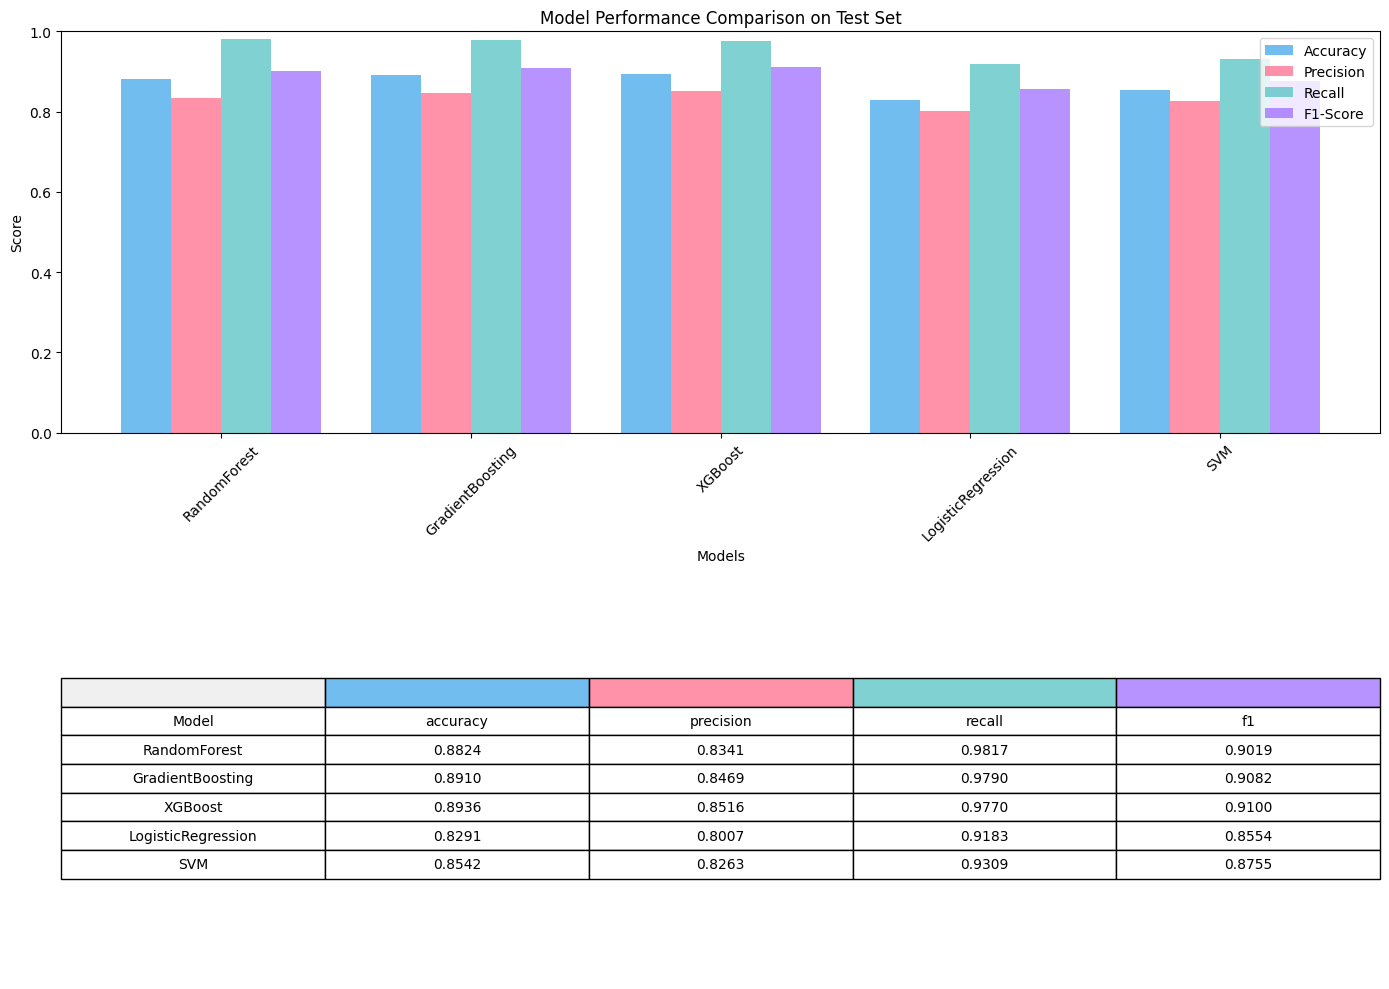


✅ All models, encoders, and performance plot with table displayed successfully!


In [6]:
import pandas as pd
import joblib
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import numpy as np
import os

# Create directories for saving models and plots if they don't exist
os.makedirs("models", exist_ok=True)
os.makedirs("plots", exist_ok=True)

# --- Step 1: Load datasets ---
train_df = pd.read_csv("UNSW_NB15_training-set.csv")
test_df = pd.read_csv("UNSW_NB15_testing-set.csv")

# Drop unnecessary columns
drop_cols = ['id', 'attack_cat']
train_df = train_df.drop(columns=[col for col in drop_cols if col in train_df.columns], errors='ignore')
test_df = test_df.drop(columns=[col for col in drop_cols if col in test_df.columns], errors='ignore')

# Define label column
LABEL_COL = "label"
y_train = train_df[LABEL_COL].apply(lambda x: 0 if x == 0 else 1)
X_train = train_df.drop(columns=[LABEL_COL])
y_test = test_df[LABEL_COL].apply(lambda x: 0 if x == 0 else 1)
X_test = test_df.drop(columns=[LABEL_COL])

# --- Step 2: Encode categorical values ---
categorical_cols = ['proto', 'service', 'state']
encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    combined_values = pd.concat([X_train[col], X_test[col]], axis=0).astype(str).unique()
    le.fit(combined_values)
    X_train[col] = le.transform(X_train[col].astype(str))
    X_test[col] = le.transform(X_test[col].astype(str))
    encoders[col] = le

# Save encoders
joblib.dump(encoders, "models/unsw_encoders.pkl")

# --- Step 3: Handle missing values ---
X_train = X_train.fillna(X_train.median())
X_test = X_test.fillna(X_test.median())

# --- Step 4: Scale numerical features (required for Logistic Regression and SVM) ---
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)
joblib.dump(scaler, "models/unsw_scaler.pkl")

# --- Step 5: Apply SMOTE to handle class imbalance ---
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)
print("SMOTE applied. New training set shape:", X_train.shape)

# --- Step 6: Define models and their hyperparameter grids ---
models = {
    "RandomForest": {
        "model": RandomForestClassifier(random_state=42, n_jobs=-1),
        "param_grid": {
            'n_estimators': [100, 200],
            'max_depth': [10, 20, None],
            'min_samples_split': [2, 5],
            'min_samples_leaf': [1, 2]
        }
    },
    "GradientBoosting": {
        "model": GradientBoostingClassifier(random_state=42),
        "param_grid": {
            'n_estimators': [100, 200],
            'learning_rate': [0.01, 0.1],
            'max_depth': [3, 5]
        }
    },
    "XGBoost": {
        "model": xgb.XGBClassifier(random_state=42, n_jobs=-1),
        "param_grid": {
            'n_estimators': [100, 200],
            'learning_rate': [0.01, 0.1],
            'max_depth': [3, 5]
        }
    },
    "LogisticRegression": {
        "model": LogisticRegression(random_state=42, max_iter=1000, n_jobs=-1),
        "param_grid": {
            'C': [0.1, 1, 10],
            'solver': ['lbfgs', 'liblinear']
        }
    },
    "SVM": {
        "model": SVC(random_state=42),
        "param_grid": {
            'C': [0.1, 1],
            'kernel': ['rbf', 'linear']
        }
    }
}

# --- Step 7: Train and evaluate models ---
results = {}
X_train_subset, _, y_train_subset, _ = train_test_split(
    X_train, y_train, test_size=0.8, random_state=42, stratify=y_train
)

for model_name, config in models.items():
    print(f"\nTraining {model_name}...")
    
    # Hyperparameter tuning on subset
    grid_search = GridSearchCV(
        config["model"],
        config["param_grid"],
        cv=3,
        scoring='f1',
        n_jobs=-1,
        verbose=1
    )
    grid_search.fit(X_train_subset, y_train_subset)
    
    # Train best model on full (SMOTE-resampled) training set
    best_model = grid_search.best_estimator_
    best_model.fit(X_train, y_train)
    
    # Evaluate on test set
    y_pred = best_model.predict(X_test)
    metrics = {
        "accuracy": accuracy_score(y_test, y_pred),
        "precision": precision_score(y_test, y_pred),
        "recall": recall_score(y_test, y_pred),
        "f1": f1_score(y_test, y_pred)
    }
    results[model_name] = {
        "best_params": grid_search.best_params_,
        "best_cv_f1": grid_search.best_score_,
        "test_metrics": metrics
    }
    
    # Save model
    joblib.dump(best_model, f"models/unsw_{model_name.lower()}.pkl")
    
    # Visualize confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Normal', 'Attack'], yticklabels=['Normal', 'Attack'])
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.savefig(f'plots/confusion_matrix_{model_name.lower()}.png')
    plt.close()
    
    print(f"{model_name} - Best parameters:", grid_search.best_params_)
    print(f"{model_name} - Best CV F1 score (on subset):", grid_search.best_score_)
    print(f"{model_name} - Test metrics:", metrics)

# --- Step 8: Summarize results ---
print("\nSummary of Results:")
for model_name, result in results.items():
    print(f"\n{model_name}:")
    print("Best Parameters:", result["best_params"])
    print("Best CV F1 Score:", result["best_cv_f1"])
    print("Test Metrics:", result["test_metrics"])

# --- Step 9: Plot performance comparison with table ---
# Prepare data for the bar chart and table
model_names = list(results.keys())
metrics = ['accuracy', 'precision', 'recall', 'f1']
metric_values = {metric: [results[model]["test_metrics"][metric] for model in model_names] for metric in metrics}

# Create figure with two subplots: one for bars, one for table
fig = plt.figure(figsize=(14, 10))

# Subplot 1: Bar chart
ax1 = fig.add_subplot(211)
bar_width = 0.2
index = np.arange(len(model_names))

# Define colors as RGB tuples (normalized to [0,1] with alpha)
colors = {
    'accuracy': (54/255, 162/255, 235/255, 0.7),
    'precision': (255/255, 99/255, 132/255, 0.7),
    'recall': (75/255, 192/255, 192/255, 0.7),
    'f1': (153/255, 102/255, 255/255, 0.7)
}

# Plot bars for each metric
ax1.bar(index, metric_values['accuracy'], bar_width, label='Accuracy', color=colors['accuracy'])
ax1.bar(index + bar_width, metric_values['precision'], bar_width, label='Precision', color=colors['precision'])
ax1.bar(index + 2 * bar_width, metric_values['recall'], bar_width, label='Recall', color=colors['recall'])
ax1.bar(index + 3 * bar_width, metric_values['f1'], bar_width, label='F1-Score', color=colors['f1'])

# Customize bar chart
ax1.set_xlabel('Models')
ax1.set_ylabel('Score')
ax1.set_title('Model Performance Comparison on Test Set')
ax1.set_xticks(index + 1.5 * bar_width)
ax1.set_xticklabels(model_names, rotation=45)
ax1.set_ylim(0, 1)
ax1.legend()

# Subplot 2: Table
ax2 = fig.add_subplot(212)
ax2.axis('off')  # Hide axes for the table

# Prepare table data
table_data = [['Model'] + metrics]
for model in model_names:
    row = [model] + [f"{results[model]['test_metrics'][metric]:.4f}" for metric in metrics]
    table_data.append(row)

# Create table
table = ax2.table(cellText=table_data,
                  loc='center',
                  cellLoc='center',
                  colColours=['#f0f0f0'] + [colors[metric] for metric in metrics],
                  colLabels=None)

# Customize table
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 1.5)  # Adjust table size

# Adjust layout to prevent overlap
plt.tight_layout()

# Display the plot and table
plt.show()

print("\n✅ All models, encoders, and performance plot with table displayed successfully!")

In [ ]:
# ---------------------------------------------------------------
# 6. Ablation Study (remove features one by one)
# ---------------------------------------------------------------
ablation_results = []
for col in X_train.columns[:10]:  # first 10 features for demo
    X_train_ablate = X_train.drop(columns=[col])
    X_test_ablate = X_test.drop(columns=[col])
    best_clf.fit(X_train_ablate, y_train)
    y_pred_ablate = best_clf.predict(X_test_ablate)
    f1 = f1_score(y_test, y_pred_ablate)
    ablation_results.append((col, f1))

ablation_df = pd.DataFrame(ablation_results, columns=["Removed Feature", "F1 Score"])
print("\nAblation Study (first 10 features):\n", ablation_df)